# An Orchestration Pattern

An Orchestration Pattern in an Agentic Framework refers to the structured coordination of agents and processes to execute a task or workflow effectively. Here an LLM with Reasoning capabilities can be used as the Orchestrator, often called a Master agent. The Master agent dynamically assigns (unlike Routing pattern, the subtasks aren't pre-defined) task to worker agents, responsible for coordinating and overseeing the collaborative tasks of worker agents, and later reduces the final output.
This pattern is well suited for building complex Multi-Agent System. For Example:
A user uploads a pdf that has both text and images embedded to a chatbot and ask to summarize. The Master agent decides to orchestrate multiple worker agents – one for analyzing text to text, and another one to analyze image to text. The final output is later synthesized (post-process) and presented to the user.

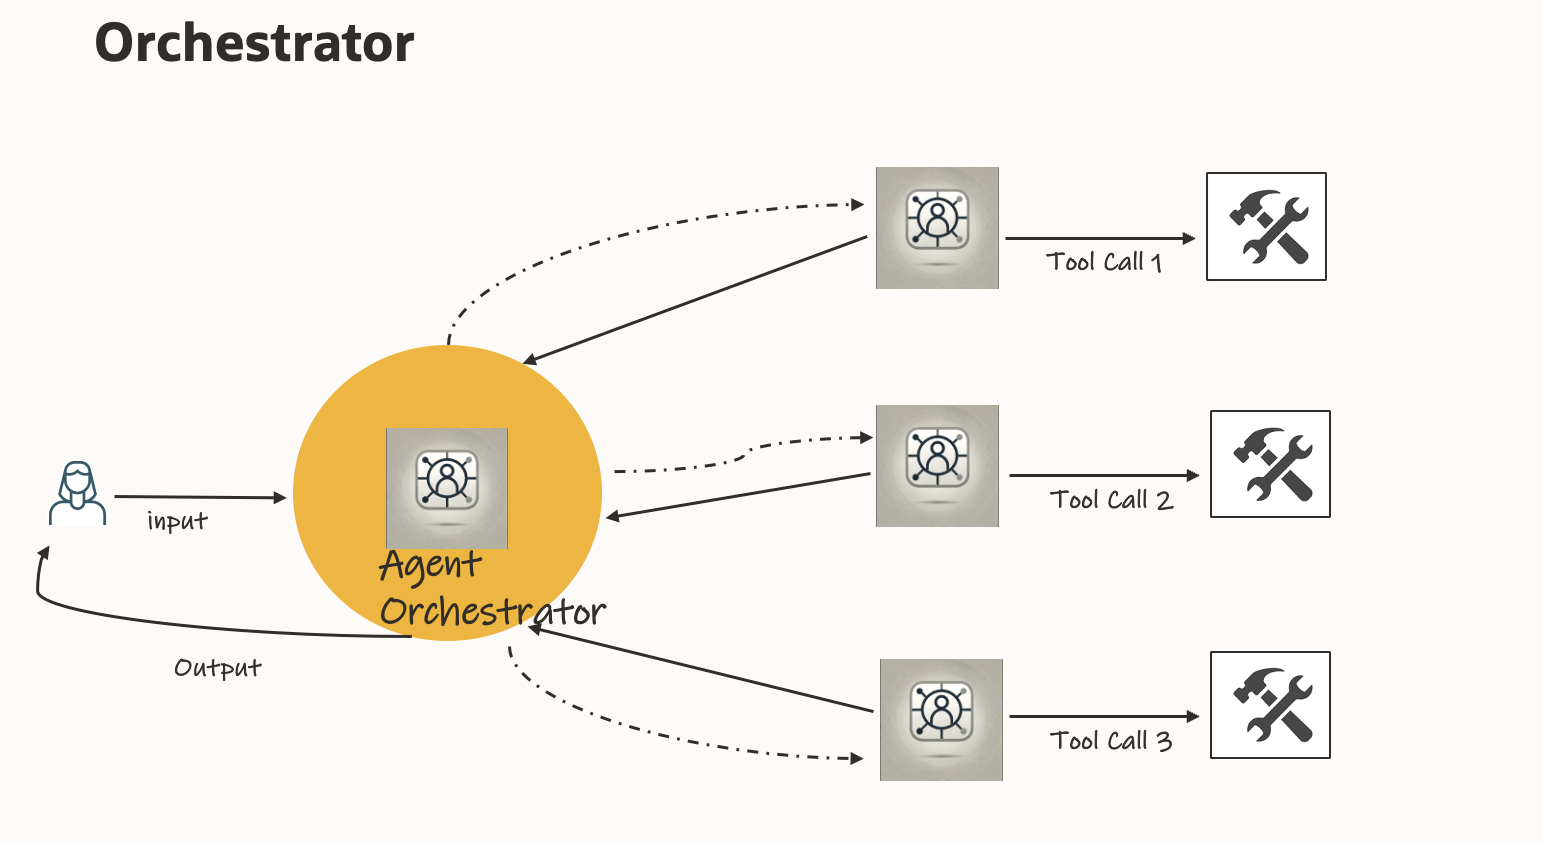

# Hierarchical Agent Teams

In our previous example ([Agent Supervisor](../agent_supervisor)), we introduced the concept of a single [supervisor node](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor) to route work between different worker nodes.

But what if the job for a single worker becomes too complex? What if the number of workers becomes too large?

For some applications, the system may be more effective if work is distributed _hierarchically_.

You can do this by composing different subgraphs and creating a top-level supervisor, along with mid-level supervisors.

To do this, let's build a simple research assistant! The graph will look something like the following:

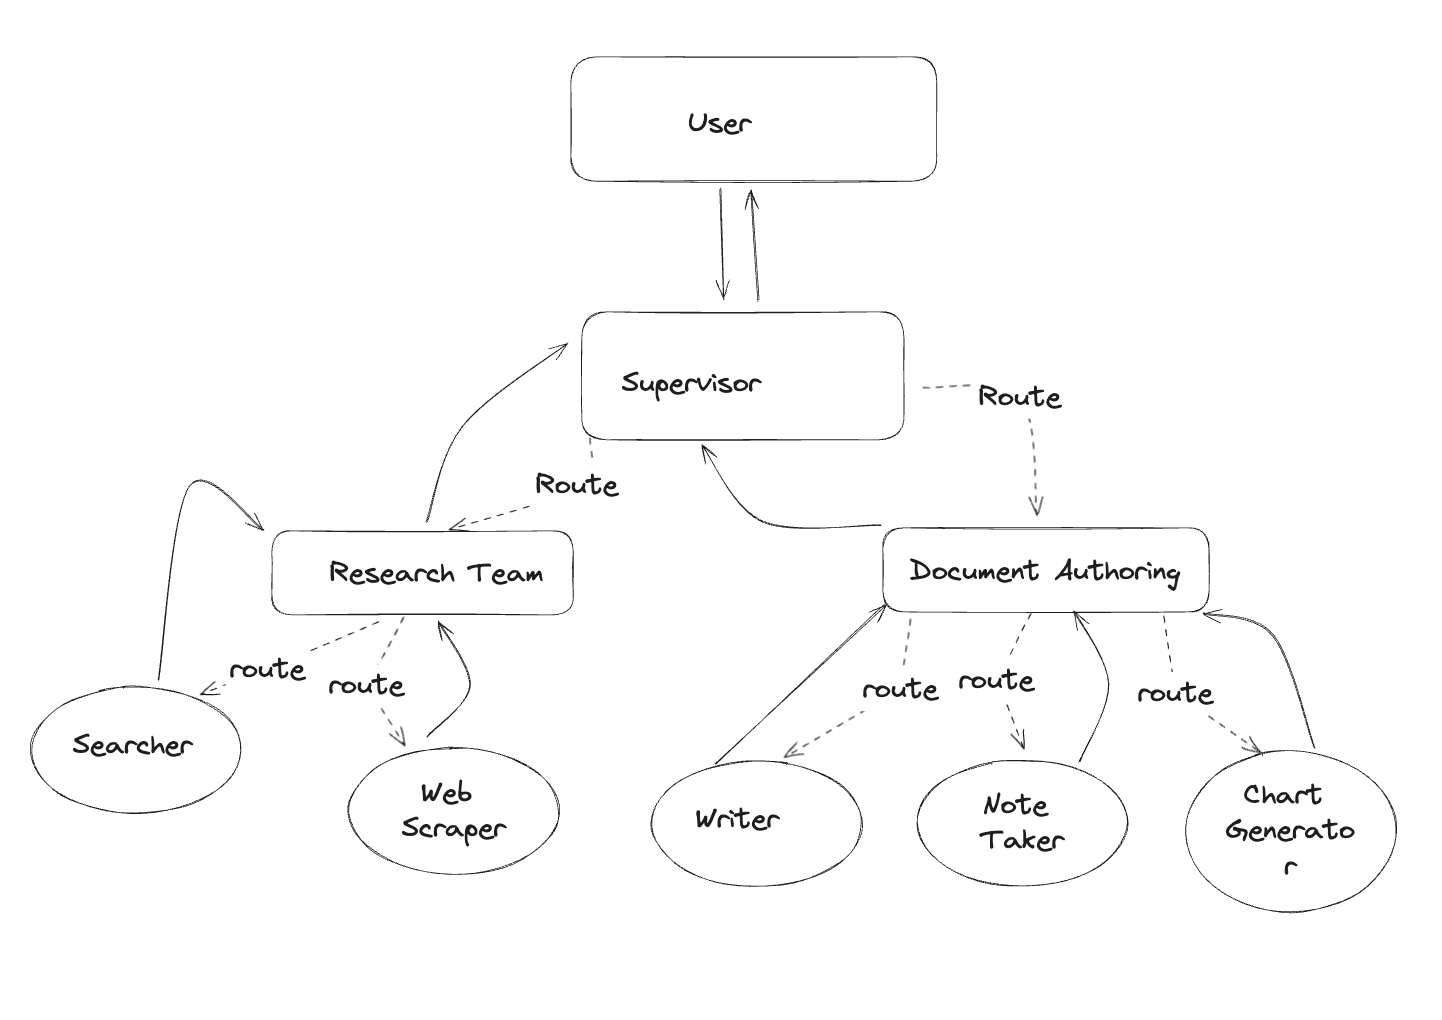

This notebook is inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al. In the rest of this notebook, you will:

1. Define the agents' tools to access the web and write files
2. Define some utilities to help create the graph and agents
3. Create and define each team (web research + doc writing)
4. Compose everything together.

## Setup

First, let's install our required packages and set our API keys

In [22]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_anthropic langchain_experimental

In [23]:
from langchain_community.chat_models.oci_generative_ai import ChatOCIGenAI
from langchain.prompts import PromptTemplate  # For creating prompts 


# Set your OCI credentials 
compartment_id = "ocid1.compartment.oc1..aaaaaaaau6esoygdsqxfz6iv3u7ghvosfskyvd6kroucemvyr5wzzjcw6aaa" 
service_endpoint = "https://inference.generativeai.us-chicago-1.oci.oraclecloud.com" 
#model_id = "meta.llama-3.3-70b-instruct"
model_id = "cohere.command-r-plus-08-2024"
# Create an OCI Cohere LLM instance 
llm_oci = ChatOCIGenAI(
    model_id= model_id,  # Specify the model you want to use 
    service_endpoint=service_endpoint,
    compartment_id=compartment_id,
    model_kwargs={"temperature": 0.7, "top_p": 0.75, "max_tokens": 1000}
) 


In [24]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


#_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Create Tools

Each team will be composed of one or more agents each with one or more tools. Below, define all the tools to be used by your different teams.

We'll start with the research team.

**ResearchTeam tools**

The research team can use a search engine and url scraper to find information on the web. Feel free to add additional functionality below to boost the team performance!

In [25]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

**Document writing team tools**

Next up, we will give some tools for the doc writing team to use.
We define some bare-bones file-access tools below.

Note that this gives the agents access to your file-system, which can be unsafe. We also haven't optimized the tool descriptions for performance.

In [26]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)

print(WORKING_DIRECTORY)

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    print("--- create_outline tool----")
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    print("--- read_document tool----")
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    print("--- write_document tool----")
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""
    print("--- edit_document tool----")
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    print("--- python_repl_tool ----")
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

/tmp/tmpnqvxx2al


## Helper Utilities

We are going to create a few utility functions to make it more concise when we want to:

1. Create a worker agent.
2. Create a supervisor for the sub-graph.

These will simplify the graph compositional code at the end for us so it's easier to see what's going on.

In [27]:
import json
import re
from typing import List, Optional, Literal, TypedDict
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages


class State(MessagesState):
    next: str


def extract_json(text: str) -> dict:
    """
    Extracts a valid JSON object from the text using regex.
    If multiple JSON objects exist, it picks the first one.
    """
    json_pattern = re.findall(r'\{.*?\}', text, re.DOTALL)
    
    for json_str in json_pattern:
        try:
            parsed_json = json.loads(json_str)

            # If LLM returns nested JSON, extract 'next' if available
            if isinstance(parsed_json, dict):
                if "supervisor" in parsed_json and "next" in parsed_json["supervisor"]:
                    return {"next": parsed_json["supervisor"]["next"]}
                if "next" in parsed_json:
                    return parsed_json
        except json.JSONDecodeError:
            continue  # Try the next match if this one fails
    
    return {"next": "FINISH"}  # Default if no valid JSON is found


def make_supervisor_node(llm: BaseChatModel, members: list[str]):
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next in **valid JSON format only**."
        " Example Response: {\"next\": \"worker_name\"} or {\"next\": \"FINISH\"}."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers are needed, route to FINISH."""
        next: Literal[tuple(options)]  # Corrected Literal usage

    def supervisor_node(state: State) -> Command[Literal[tuple(members) + ("__end__",)]]:
        """An LLM-based router."""
        messages = [HumanMessage(content=system_prompt)] + state["messages"]

        # Get LLM response
        response_text = llm.invoke(messages).content  # Ensure we extract .content
        
        response = extract_json(response_text)  # Use robust JSON extraction

        goto = response.get("next", "FINISH")  # Default to FINISH if missing

        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

## Define Agent Teams

Now we can get to define our hierarchical teams. "Choose your player!"

### Research Team

The research team will have a search agent and a web scraping "research_agent" as the two worker nodes. Let's create those, as well as the team supervisor.

In [28]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

#llm_openai = ChatOpenAI(model="gpt-4o")

search_agent = create_react_agent(llm_oci, tools=[tavily_tool])


def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


web_scraper_agent = create_react_agent(llm_oci, tools=[scrape_webpages])


def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


research_supervisor_node = make_supervisor_node(llm_oci, ["search", "web_scraper"])

Now that we've created the necessary components, defining their interactions is easy. Add the nodes to the team graph, and define the edges, which determine the transition criteria.

In [29]:
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

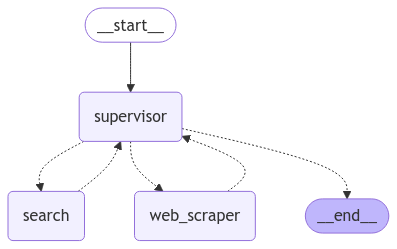

In [30]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

We can give this team work directly. Try it out below.

In [31]:
for s in research_graph.stream(
    {"messages": [("user", "when is Taylor Swift's next tour?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content='There are rumours that Taylor Swift will be going on tour in 2026, after releasing a new album.', additional_kwargs={}, response_metadata={}, name='search', id='bd675f0a-a991-41a5-a48c-fdcb9ebd4026')]}}
---
{'supervisor': {'next': '__end__'}}
---


In [32]:
for s in research_graph.stream(
    {"messages": [("user", "What are the latest advancements in artificial intelligence?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content='The latest advancements in artificial intelligence include:\n- AI agents developed by OpenAI were able to learn to use tools in an experiment based on multi-agent competition, without being deliberately taught to do so.\n- AI developments solution models network behavior by using machine learning to enhance threat detection.\n- Microsoft Pix, another popular machine learning tool, uses recent AI developments to select the best three shots out of ten frames captured.\n- Deep learning in natural language processing has helped develop applications that understand, interpret and generate human speech and language.\n- A novel 6D pose dataset designed to improve robotic grasping accuracy and adaptability in industrial settings.\n- A laser-based artificial neuron that fully emulates the functions, dynamics and information processing of a biological graded neuron, which could lead to new breakthroughs.\n- An 

### Document Writing Team

Create the document writing team below using a similar approach. This time, we will give each agent access to different file-writing tools.

Note that we are giving file-system access to our agent here, which is not safe in all cases.

In [33]:
#llm_openai = ChatOpenAI(model="gpt-4o")

doc_writer_agent = create_react_agent(
    llm_oci,
    tools=[write_document, edit_document, read_document],
    prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


note_taking_agent = create_react_agent(
    llm_oci,
    tools=[create_outline, read_document],
    prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


chart_generating_agent = create_react_agent(
    llm_oci, tools=[read_document, python_repl_tool]
)


def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


doc_writing_supervisor_node = make_supervisor_node(
    llm_oci, ["doc_writer", "note_taker", "chart_generator"]
)

With the objects themselves created, we can form the graph.

In [34]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

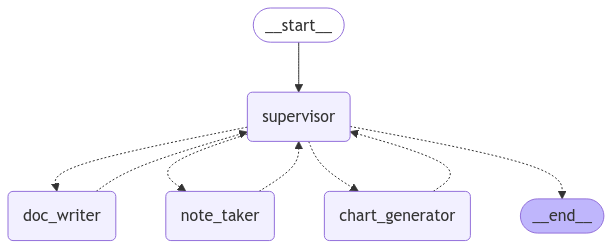

In [35]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [36]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Write an outline for poem about cats and then write the poem to disk.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'doc_writer'}}
---
--- write_document tool----
{'doc_writer': {'messages': [HumanMessage(content='I have written a poem about cats to disk. You can find it in the file `cats.txt`.', additional_kwargs={}, response_metadata={}, name='doc_writer', id='2751e933-6529-4279-84d0-728760c4b00c')]}}
---
{'supervisor': {'next': 'note_taker'}}
---
--- read_document tool----
--- create_outline tool----
{'note_taker': {'messages': [HumanMessage(content='I have created an outline for the poem and saved it to `cats_outline.txt`.', additional_kwargs={}, response_metadata={}, name='note_taker', id='bd7494f4-4ef4-44c6-a2bf-24776f4237a1')]}}
---
{'supervisor': {'next': 'note_taker'}}
---
--- create_outline tool----
{'note_taker': {'messages': [HumanMessage(content='I have created an outline for a poem about cats and saved it to the file `cats_outline.txt`.', additional_kwargs={}, response_metadata={}, name='note_taker', id='8f4b1df8-9b3b-4e12-a847-cd5bcb033243')]}}
---
{'supervisor

## Add Layers

In this design, we are enforcing a top-down planning policy. We've created two graphs already, but we have to decide how to route work between the two.

We'll create a _third_ graph to orchestrate the previous two, and add some connectors to define how this top-level state is shared between the different graphs.

In [37]:
from langchain_core.messages import BaseMessage

#llm_openai = ChatOpenAI(model="gpt-4o")

teams_supervisor_node = make_supervisor_node(llm_oci, ["research_team", "writing_team"])

In [38]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )


# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

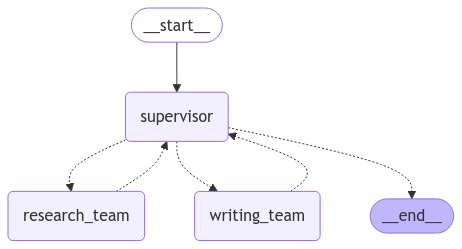

In [39]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [41]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Write a blog about Agentic Architecture")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'supervisor': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content="Unfortunately, I can't search for Agentic Architecture at the moment. Can I help you with anything else?", additional_kwargs={}, response_metadata={}, name='research_team', id='072b4b5f-e63e-4015-b6be-e35b13501103')]}}
---
{'supervisor': {'next': '__end__'}}
---
